# Experiment Overview

How to design and run an experiment for benchmarking a HuggingFace AutoModel for NLP with Sagemaker? Let's find out!

## Table of Contents:

1. [Generate Design](#Generate-Design)
2. [Install/Import Required Packages](#Install/Import-Required-Packages)
3. [Load Experimental Design](#Load-Experimental-Design)
4. [Add Hyperparameters and Customization to Experiment](#Add-Hyperparameters-and-Customization-to-Experiment)
5. [Export design to individual csv files](#Export-design-to-individual-csv-files)
6. [Upload Data to S3](#Upload-Data-to-S3)
7. [Execute Experiments](#Execute-Experiments)

### Design Automation:
Steps 3 through 5 are equivalently taken care of by running the command "make experiment" in the terminal, using the Makefile and make_experiment.py script. The make_experiment.py script is identical to the notebook code below in sections 3 - 5, and once you are happy with your design/exploration, you can modify the make_experiment.py file to run these steps automatically with a single command.

## 1. Generate Design

First, a .csv file containing the experimental design must be uploaded to data/raw. (See "experimental_design.csv" for an example of this).
An experiment can be designed in many ways using many types of software. For this experiment, the JMP Custom Design Tool was used to create an initial experimental design. The data/external folder contains screenshots from JMP regarding the design quality. The design is limited to 4 nodes due to account level resource restrictions.

The file experimental_design.csv in data/interim can be replaced with any experimental design of the reader's choosing.

## 2. Install/Import Required Packages

In [1]:
!pip install -q datasets
!pip install -q transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2021.4.0 requires fsspec==2021.04.0, but you have fsspec 2021.7.0 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker

# import custom run experiment functions
from run_experiment import *

## 3. Load Experimental Design

Load it in from the data/raw folder. If you have changed the design and file name, please change the file name called below. This design represents the minimum information required to see our trends of interest.

In [25]:
# load raw experimental design designed previously
exp_design = pd.read_csv('../data/raw/experimental_design.csv')
display(exp_design)

,num_nodes,dataset_size,train_time,f1,billable_seconds,cost
0,4,600000,NaN,NaN,NaN,NaN
1,4,100000,NaN,NaN,NaN,NaN
2,4,1000000,NaN,NaN,NaN,NaN
3,2,1000000,NaN,NaN,NaN,NaN
4,1,100000,NaN,NaN,NaN,NaN
5,4,600000,NaN,NaN,NaN,NaN
6,1,1000000,NaN,NaN,NaN,NaN
7,1,100000,NaN,NaN,NaN,NaN
8,4,1000000,NaN,NaN,NaN,NaN
9,1,600000,NaN,NaN,NaN,NaN


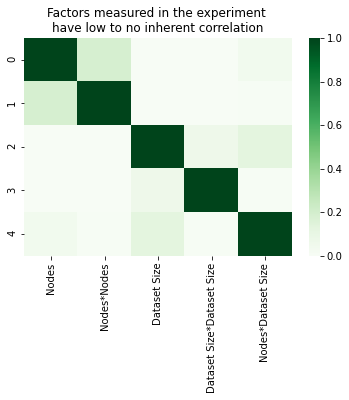

In [31]:
# confounding pattern previously calculated
conf_pattern = pd.read_csv('../data/raw/confounding_pattern.csv')
sns.heatmap(conf_pattern.iloc[:,1:], cmap = 'Greens')
plt.title("Factors measured in the experiment \nhave low to no inherent correlation");

## 4. Add Hyperparameters and Customization to Experiment

In the next section, we add all the information our training jobs will need to know to run all experiments.

### 4a) Calculate the epochs required to compare training with different numbers of samples:

In order to compare training jobs with different numbers of samples (also referred to as "dataset sizes" here), we need to ensure the experiment is controlled in terms of the number of steps (weight updates) made during training for each model. These steps represent the learning opportunities for the model. Hence, if one model is given more learning opportunities than another, it will outperform, and the comparison of their metrics won't be objective.

<b>For example, take the case of training a model on a 1 GPU instance, i.e. an ml.p3.2xlarge, for 3 epochs, with a batch size of 100 samples:</b>
* Dataset Size: 100,000 samples, batch size = 100, steps in each epoch = 1,000 (100,000/100)
    * 3 Epochs: 1,000 steps per epoch * 3 epochs = 3,000 steps 
* Dataset Size: 1,000,000 samples, batch size = 100, steps in each epoch = 10,000 (1,000,000/100)
    * 3 Epochs: 10,000 steps per epoch * 3 epochs = 30,000 steps 
    
With this discrepancy in steps, the results across multiple dataset sizes cannot be compared apples to apples in an experiment, as the second dataset size has 10x more steps than the first example. 

<b>Therefore, the number of steps should be fixed whenever we want to compare the results of different dataset sizes. The epochs are adjusted to achieve this.</b>

Rearranging the equation to solve for the number of epochs ...

* num_steps_per_epoch = num_samples/batch_size
* num_epochs = num_steps/num_steps_per_epoch

Here's an example calculation below.

The parameters selected in the present experiment were the best obtainable in view of time and resource constraints - however they can no doubt be improved or tuned to the needs of the deep learning practitioner.

In [3]:
# For the case of 1 GPU - num steps selected via guess and check to get whole numbered epochs
num_steps = 84375 
batch_size = 32*1 # for 1 GPU, change value to adjust for number of GPUs used
num_samples = exp_design['dataset_size'].values*0.9 # 90% of each size is used for training

num_steps_per_epoch = num_samples/batch_size

# calculate the number of epochs to be passed as hyperparameters for each experiment
num_epochs = num_steps/num_steps_per_epoch
print("\nTraining dataset sample sizes:", num_samples)
print("\nRequired epochs for different sample sizes on 1 GPU:", num_epochs)


Training dataset sample sizes: [540000.  90000. 900000. 900000.  90000. 540000. 900000.  90000. 900000.
 540000.  90000.  90000. 900000.  90000. 540000.]

Required epochs for different sample sizes on 1 GPU: [ 5. 30.  3.  3. 30.  5.  3. 30.  3.  5. 30. 30.  3. 30.  5.]


### 4b) Select the global batch sizes, learning rates, and number of steps for different compute power:

<b>Hyperparameter Selection:</b>

* Aim was to fix as many parameters as possible, and to collect interpretable data with minimal time spent on troubleshooting
* Parameters Selected:
    * per_device_batch_size: 32 (HuggingFace suggested default)
    * learning_rate: 5e-5 (HuggingFace suggested default)
    * global_batch_size: varied based on number of GPUs in use
    * num_epochs: 3 (1M samples), 5 (6M samples), 30 (100k samples)
    * num_steps: calculated (see above)
        * based on global batch size and epochs for the experiment 
        * constant across dataset sizes at a given number of GPUs and global batch size
        * num_steps = num_epochs x num_samples/global_batch_size

NOTE: it is common practice in deep learning to vary the learning rate with the global batch size. For the sake of having another experimental control, the learning rate was kept constant during experimentation. However, to improve the performance of the models, the learning rate can be adjusted proportionally with global batch size to the desired level of fine-tuning. Additionally, the experiment could be re-designed to fix the global batch size and vary the per device batch size, or keep the number of steps constant across all runs. The deep learning practitioner can select the setup that works best for their needs, and generate the experimental design accordingly. 

Additional info we require to set up our experiment:

* automodel_name: or "checkpoint", used to automatically configure both tokenization and modelling
* dataset_name: name to load from the huggingface datasets hub
* epochs: calculated above
* num_parameters_tumed: custom to each model, params for distilbert below
* s3_bucket: customize (TO DO: load from environment variable)

Let's add this info into the experimental design and save it in the interim folder. The table will be completed by inserting the final values from the experiment execution.

In [4]:
s3_bucket = os.getenv("BUCKET_NAME")

In [5]:
exp_design.insert(loc = 0, column = 'dataset_name', value = 'amazon_polarity')
exp_design.insert(loc = 1, column = 'automodel_name', value = 'distilbert-base-uncased')
exp_design.insert(loc = 2, column = 'num_parameters_tuned', value = 66955010) # constant for this model
exp_design.insert(loc = 3, column = 's3_bucket', value = s3_bucket) # constant for this model
exp_design.insert(loc = 4, column = 'per_device_train_batch_size', value = batch_size) # calculated above
exp_design.insert(loc = 5, column = 'learning_rate', value = 5e-5)
exp_design.insert(loc = 6, column = 'epochs', value = num_epochs) # calculated above


We can add even more info to the design now, by mapping the number of nodes to the types of instances needed. Additionally, we should state the number of GPUs, EBS volume required (more for smaller instances), the price per hour based on the instance type, and whether or not parallelism is enabled.

In [6]:
# map the num_nodes column to specific factor levels for experimentation
instance_mapper = {1:'ml.p3.2xlarge', 2:'ml.p3.16xlarge', 4:'ml.p3.16xlarge'}
gpu_mapper = {1:1, 2:16, 4:32}
parallel_enabled_mapper = {1:False, 2:True, 4:True}
EBS_volume_mapper = {'ml.p3.2xlarge':1024, 'ml.p3.8xlarge':1024, 'ml.p3.16xlarge':30} # leave default for 16xlarges, add more storage for small instances
price_mapper = {"ml.p3.2xlarge": 3.825, "ml.p3.8xlarge":14.688, "ml.p3.16xlarge":28.152} # hourly instance pricing from SageMaker website


In [7]:
exp_design.insert(loc = 7, column = 'instance_type', value = exp_design['num_nodes'].map(instance_mapper))
exp_design.insert(loc = 8, column = 'num_gpus', value = exp_design['num_nodes'].map(gpu_mapper))
exp_design.insert(loc = 9, column = 'global_batch_size', value = exp_design['num_gpus']*exp_design['per_device_train_batch_size']) 
exp_design.insert(loc = 10, column = 'num_steps', value = np.rint((exp_design['epochs'] * exp_design['dataset_size']*0.9)/exp_design['global_batch_size'])) # note - in the future num steps could be held constant across exps instead
exp_design.insert(loc = 11, column = 'hourly_price', value = exp_design['instance_type'].map(price_mapper))
exp_design.insert(loc = 12, column = 'volume_size', value = exp_design['instance_type'].map(EBS_volume_mapper)) 
exp_design.insert(loc = 13, column = 'parallel_enabled', value = exp_design['num_nodes'].map(parallel_enabled_mapper)) 

Let's view the completed design.

In [8]:
display(exp_design)

,dataset_name,automodel_name,num_parameters_tuned,s3_bucket,per_device_train_batch_size,learning_rate,epochs,instance_type,num_gpus,global_batch_size,num_steps,hourly_price,volume_size,parallel_enabled,num_nodes,dataset_size,train_time,f1,billable_seconds,cost
0,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,5.0,ml.p3.16xlarge,32,1024,2637.0,28.152,30,True,4,600000,NaN,NaN,NaN,NaN
1,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,30.0,ml.p3.16xlarge,32,1024,2637.0,28.152,30,True,4,100000,NaN,NaN,NaN,NaN
2,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,3.0,ml.p3.16xlarge,32,1024,2637.0,28.152,30,True,4,1000000,NaN,NaN,NaN,NaN
3,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,3.0,ml.p3.16xlarge,16,512,5273.0,28.152,30,True,2,1000000,NaN,NaN,NaN,NaN
4,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,30.0,ml.p3.2xlarge,1,32,84375.0,3.825,1024,False,1,100000,NaN,NaN,NaN,NaN
5,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,5.0,ml.p3.16xlarge,32,1024,2637.0,28.152,30,True,4,600000,NaN,NaN,NaN,NaN
6,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,3.0,ml.p3.2xlarge,1,32,84375.0,3.825,1024,False,1,1000000,NaN,NaN,NaN,NaN
7,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,30.0,ml.p3.2xlarge,1,32,84375.0,3.825,1024,False,1,100000,NaN,NaN,NaN,NaN
8,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,3.0,ml.p3.16xlarge,32,1024,2637.0,28.152,30,True,4,1000000,NaN,NaN,NaN,NaN
9,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,5.0,ml.p3.2xlarge,1,32,84375.0,3.825,1024,False,1,600000,NaN,NaN,NaN,NaN


In [9]:
# save completed design to file
exp_design.to_csv('../data/interim/experimental_design.csv', index_label = 'run_id')

Now that we have the format of our ideal design, we can add any additional experiments to the list above the  minimum required generated in JMP.

Below, we add these additional centrepoints to the design, for more data, and write it to the file we just exported.

In [10]:
from csv import writer

# if any additional data points desired, add additional rows to csv with custom params
cp1 = [15,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,5.0,'ml.p3.8xlarge',4,128,21094,14.688,1024,False,1,600000]
cp2 = [16,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',16,5e-05,5.0,'ml.p3.16xlarge',8,128,10547,28.152,1024,True,1,600000] # pd batch size adjusted for cuda error
cp3 = [17,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,30.0,'ml.p3.16xlarge',8,256,10547,28.152,1024,True,1,100000]
cp4 = [18,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,3.0,'ml.p3.16xlarge',8,256,10547,28.152,1024,True,1,1000000]
cp5 = [19,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,30.0,'ml.p3.8xlarge',4,128,21094,14.688,1024,False,1,100000]
cp6 = [20,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,3.0,'ml.p3.8xlarge',4,128,21094,14.688,1024,False,1,1000000]
cp7 = [21,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,2.83e-4,30.0,'ml.p3.16xlarge',32,1024,2637,28.152,30,True,4,100000] # run tmo - sqrt law
cp8 = [22,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,2.83e-4,3.0,'ml.p3.16xlarge',32,1024,2637,28.152,30,True,4,1000000] # run tmo - sqrt law
cp9 = [23,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,30.0,'ml.p3.16xlarge',8,256,10547,28.152,1024,False,1,100000]
cp10 = [24,'amazon_polarity','distilbert-base-uncased',66955010,'hf-benchmarking-samstu',32,5e-05,3.0,'ml.p3.16xlarge',8,256,10547,28.152,1024,False,1,1000000]

# Open our existing CSV file in append mode
# Create a file object for this file
with open('../data/interim/experimental_design.csv', 'a') as f_object:
  
    # Pass this file object to csv.writer()
    # and get a writer object
    writer_object = writer(f_object)
  
    # Pass the list as an argument into
    # the writerow()
    writer_object.writerow(cp1)
    writer_object.writerow(cp2)
    writer_object.writerow(cp3)
    writer_object.writerow(cp4)
    writer_object.writerow(cp5)
    writer_object.writerow(cp6)

    # increased learn rate to compare with lr controlled version
    writer_object.writerow(cp7)
    writer_object.writerow(cp8)
    writer_object.writerow(cp9)
    writer_object.writerow(cp10)
  
    #Close the file object
    f_object.close()

exp_design = pd.read_csv('../data/interim/experimental_design.csv')
display(exp_design)


,run_id,dataset_name,automodel_name,num_parameters_tuned,s3_bucket,per_device_train_batch_size,learning_rate,epochs,instance_type,num_gpus,...,num_steps,hourly_price,volume_size,parallel_enabled,num_nodes,dataset_size,train_time,f1,billable_seconds,cost
0,0,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,5.0,ml.p3.16xlarge,32,...,2637.0,28.152,30,True,4,600000,NaN,NaN,NaN,NaN
1,1,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,30.0,ml.p3.16xlarge,32,...,2637.0,28.152,30,True,4,100000,NaN,NaN,NaN,NaN
2,2,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,3.0,ml.p3.16xlarge,32,...,2637.0,28.152,30,True,4,1000000,NaN,NaN,NaN,NaN
3,3,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,3.0,ml.p3.16xlarge,16,...,5273.0,28.152,30,True,2,1000000,NaN,NaN,NaN,NaN
4,4,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,30.0,ml.p3.2xlarge,1,...,84375.0,3.825,1024,False,1,100000,NaN,NaN,NaN,NaN
5,5,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,5.0,ml.p3.16xlarge,32,...,2637.0,28.152,30,True,4,600000,NaN,NaN,NaN,NaN
6,6,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,3.0,ml.p3.2xlarge,1,...,84375.0,3.825,1024,False,1,1000000,NaN,NaN,NaN,NaN
7,7,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,30.0,ml.p3.2xlarge,1,...,84375.0,3.825,1024,False,1,100000,NaN,NaN,NaN,NaN
8,8,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,3.0,ml.p3.16xlarge,32,...,2637.0,28.152,30,True,4,1000000,NaN,NaN,NaN,NaN
9,9,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.000050,5.0,ml.p3.2xlarge,1,...,84375.0,3.825,1024,False,1,600000,NaN,NaN,NaN,NaN


## 5. Export design to individual csv files

Ideally, this would run in one loop. However, to mitigate capacity planning restrictions, experiment runs will be executed individually.

In [11]:
# export desired runs into individual csvs
for ix, val in exp_design.iterrows():
    exp_design.loc[exp_design.index == ix].to_csv(f'../data/interim/run{ix}_experimental_design.csv', index_label = 'run_id')

## 6. Upload Split and Tokenized Dataset to S3 According to Experimental Design

On first setup of your experiment, you can prep and upload your data to s3 all in one go using the makefile command "prep_data_and_sync_s3". Fair warning - for large datasets this can take some time. Fortunately - you will only have to do it once!

Based on the experimental design you exported to csv above in the in data/interim folder, it will get data from HuggingFace and generate s3 paths for the experiment custom to the number of samples you are interested in. (Called "dataset size," which is equivalent to "number of samples" in deep learning). If you are using the distilBERT model and amazon-polarity dataset this repo came with, it will work out of the box using the Makefile.

<b> Use the Makefile: </b>
* Open the terminal, navigate to your project root directory
* Type "make prep_data_and_sync_s3" and hit enter
* Wait for the upload to complete. You will see the message: "Upload completed! Check out your s3 bucket to see for yourself." 

<b> Alternatively, use this Notebook: </b>
* Uncomment the below cell and run it, calling the wrangle_datasets.py script

### If you are using a different dataset than amazon-polarity...
1. Skip step 6 entirely.
2. Upload the data yourself to S3.
3. Customize the input paths in run_experiment.py to the experient knows where to look for your data

Be sure to customize your SageMaker training script as well in src/modes/train_model.py







In [11]:
# %run ../src/data/wrangle_datasets.py

## 7. Execute experiments

Ideally, we would be able to execute all experiments in one loop, in the randomized order of the experimental design from JMP. However, any capacity planning restrictions will cause the loop to terminate.

Hence, below, experimental runs can be executed individually, by calling the run_experiment function.

The experiments can be run one at a time by calling the cell below. Alternatively, if you are able to open multiple sagemaker notebooks and clone your customized version of this repo to them, you can parallelize the running of experiments, and simply commit the result files as they come in back to your shared git branch. Once you have run all your desired experiments, you can analyze results by following instructions in the analyze_results notebook.

In [12]:
# run 24
run_experiment(exp_design_path = '../data/interim/run24_experimental_design.csv')

Configuration settings:
sagemaker role arn: arn:aws:iam::513667113968:role/service-role/AmazonSageMaker-ExecutionRole-20210610T144190
sagemaker bucket: hf-benchmarking-samstu
sagemaker session region: us-east-1
Settings for this experiment:


,run_id,run_id.1,dataset_name,automodel_name,num_parameters_tuned,s3_bucket,per_device_train_batch_size,learning_rate,epochs,instance_type,...,num_steps,hourly_price,volume_size,parallel_enabled,num_nodes,dataset_size,train_time,f1,billable_seconds,cost
0,24,24,amazon_polarity,distilbert-base-uncased,66955010,hf-benchmarking-samstu,32,0.00005,3.0,ml.p3.16xlarge,...,10547.0,28.152,1024,False,1,1000000,NaN,NaN,NaN,NaN


None
Dataset sizes: [1000000]
Preparing to initiate experiment w/ run number: 24
Starting Training Job.
Train input path: s3://hf-benchmarking-samstu/datasets/amazon_polarity/1000000/train
2021-08-13 19:49:20 Starting - Starting the training job.

KeyboardInterrupt: 

# Manual Result Generation

If one of the training jobs executes in a different Sagemaker Notebook, and you want to generate its results in the notebook you're in, you can use the below code to generate the results of your successfully executed training experiment manually.

Simply pass the training job name, and the run number according to your design, to generate the results for the experiment in the notebook you are in.

In [13]:
# MANUAL LOOKUP 
# after training job execution, get response values
run_job_name = "experiment-run21-13-01-56-39"
run_number = 21

metrics_session = sagemaker.session.Session() # use to get metrics after training

print("Training job finished. Fetching metrics.")
train_metrics = sagemaker.TrainingJobAnalytics(run_job_name).dataframe()
run_f1 = train_metrics['value'].values[0]
print("Run {} \nF1: {}".format(run_number, run_f1))

# get train time and billable seconds
job_description = metrics_session.describe_training_job(run_job_name)
run_train_time = job_description['TrainingTimeInSeconds']
run_bill_time = job_description['BillableTimeInSeconds']

print("Train Time:", run_train_time, "Bill Time:", run_bill_time)

# write results to file
run_results = {"run_number":run_number, "job_name":run_job_name, "training_time":run_train_time, "bill_time":run_bill_time, "mean_f1":run_f1}

with open('../data/interim/run{}_results.txt'.format(run_number), 'w') as convert_file:
    convert_file.write(json.dumps(run_results))

print("Experiment {} complete. Results written to ..data/interim folder.".format(run_number))

Training job finished. Fetching metrics.
Run 21 
F1: 0.924390807510588
Train Time: 3143 Bill Time: 3143
Experiment 21 complete. Results written to ..data/interim folder.
